### 1. Scope Project & Gather Data

In [1]:
# Import libraries
import pandas as pd
import psycopg
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

In [33]:
# Load environment variables from .env
load_dotenv(override=True)

HOST = os.getenv("PGHOST")
DB = os.getenv("PGDATABASE")
USER = os.getenv("PGUSER")
PASSWORD = os.getenv("PGPASSWORD")
PORT = os.getenv("PGPORT", 5432)

In [34]:
# Connect to PostgreSQL
try:
    conn = psycopg.connect(
        host=HOST,
        dbname=DB,
        user=USER,
        password=PASSWORD,
        port=PORT
    )
except Exception as e:
    print("Error connecting to the database:", e)

In [35]:
# Pull movies data into pandas
query = """
SELECT *
FROM public.movies;
"""
movies = pd.read_sql(query, conn)

/var/folders/c0/9vyfkxzn07v96t62b5tl1_fr0000gn/T/ipykernel_1367/2626728460.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  movies = pd.read_sql(query, conn)


In [36]:
movies.head()
movies.to_csv("../data/movies_raw.csv", index=False)

### 2. Data Cleaning & Exploratory Data Analysis

#### 2.1 Write Python code to do the following with the movies data:
1. Find the number of movies that were released in theatres each year.
* There are some erroneous values in the data
* Visualize the number of movies each year and describe what you see
* Explain what assumptions and fixes you plan to make in the data as you move forward with your analysis

In [161]:
movies = pd.read_csv("../data/movies_raw.csv")

In [162]:
# Convert to datetime and extract year
movies = movies.copy() # ensures movies is its own DataFrame
movies["in_theaters_date"] = pd.to_datetime(movies["in_theaters_date"], errors="coerce") # convert to datetime
movies["release_year"] = movies["in_theaters_date"].dt.year # extract released year
movies = movies.dropna(subset=["release_year"]) # Drop null values

# Group dataset by year and take a brief look
year_counts = (
    movies.groupby("release_year")
                .size()
                .reset_index(name="movie_count")
)

# Take a brief look of "released_year"
year_counts.head(), year_counts.tail()

(   release_year  movie_count
 0        1970.0           62
 1        1971.0           67
 2        1972.0           70
 3        1973.0           81
 4        1974.0           63,
     release_year  movie_count
 95        2065.0           55
 96        2066.0           56
 97        2067.0           65
 98        2068.0           59
 99        2069.0           56)

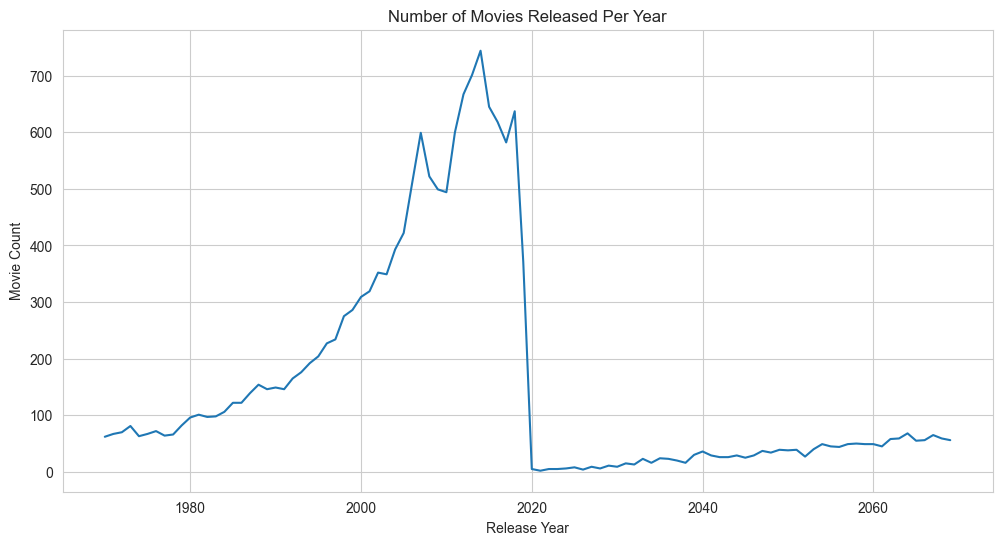

In [163]:
# Make a plot
plt.figure(figsize=(12,6))
sns.lineplot(data=year_counts, x="release_year", y="movie_count")
plt.title("Number of Movies Released Per Year")
plt.xlabel("Release Year")
plt.ylabel("Movie Count")
plt.grid(True)
plt.show()

In [164]:
# My strategy to clean dataset
after2020 = movies["release_year"] > 2020 # Identify release years that are clearly too high
movies.loc[after2020,"release_year"] = movies.loc[after2020,"release_year"] - 100 # Subtract 100 from those years
movies["release_year"] = movies["release_year"].astype(int) # Convert the values to int if it was floats after datetime conversion

##### A Short Summary:
The number of movies released each year gradually increases from the 1970s through the 2000s. The number is a pike around the 2010s. There is a sharp drop around 2020–2021 likely due to COVID-19. Several movies had release years far in the future (e.g., 2069), which are clearly incorrect, and a few records have missing or null dates. To address this, I subtracted 100 from the release year for movies after 2020 and dropped records with null release years.

#### 2.2 Looking only at movies that were released in theatres before 2010:
* Find the 5 highest rated movies by critics (critic_rating)
* Find the 5 highest rated movies by the general audience (audience_rating)
* Take a look at the movie titles – these top movies don’t seem very popular

In [165]:
before2010 = movies[movies['release_year'] < 2010].copy() # get all movies before 2010

# Find the 5 highest rated movies by critics
top5_critics = (
    before2010[['movie_title', 'critic_rating']]
    .dropna(subset=['critic_rating'])
    .sort_values(by='critic_rating', ascending=False)
    .head(5)
)

top5_critics

,movie_title,critic_rating
534,The Invisible Man,100
9832,Mickey's Christmas Carol,100
14558,The Magician (Ansiktet),100
14562,The Man from Planet X,100
12140,San Francisco,100


In [166]:
# Find the 5 highest rated movies by the general audience
top5_audience = (
    before2010[['movie_title', 'audience_rating']]
    .dropna(subset=['audience_rating'])
    .sort_values(by='audience_rating', ascending=False)
    .head(5)
)

top5_audience

,movie_title,audience_rating
1283,La Ciudad (The City),100.0
222,Prima Ballerina,100.0
1846,Ice People,100.0
3229,Been Rich All My Life,100.0
12463,The Shawshank Redemption,98.0


##### A Short Summary:
The highest rated movies among critics are different from the ones among general audiences before 2010. It may because they have different motivations and perspectives: critics focus on technical and artistic merits, while audiences primarily seek entertainment and emotional connection.

#### 2.3 Create a new DataFrame containing only “popular” movies that were released in theatres before 2010.
* Assume popular movies are those with more audience reviews than the
average number of audience reviews of all movies before 2010
* Find the 5 highest rated movies by critics (critic_rating)
* Find the 5 highest rated movies by the general audience (audience_rating)
* Take a look at the movie titles – these top movies should make more sense

In [167]:
popular_movies_pre2010 = before2010[before2010['audience_count'] > before2010['audience_count'].mean()].copy() # get popular movies

# Find the 5 highest rated movies by critics
top5_popular_critics = (
    popular_movies_pre2010[['movie_title', 'critic_rating']]
        .dropna(subset=['critic_rating'])
        .sort_values(by='critic_rating', ascending=False)
        .head(5)
)

top5_popular_critics

,movie_title,critic_rating
13557,The Terminator,100
9636,Mary Poppins,100
15440,Toy Story 2,100
15439,Toy Story,100
11227,Pinocchio,100


In [168]:
# Find the 5 highest rated movies by the general audience
top5_popular_audience = (
    popular_movies_pre2010[['movie_title', 'audience_rating']]
        .dropna(subset=['audience_rating'])
        .sort_values(by='audience_rating', ascending=False)
        .head(5)
)

top5_popular_audience

,movie_title,audience_rating
6747,The Godfather,98.0
12463,The Shawshank Redemption,98.0
4435,Cidade de Deus (City of God),97.0
6748,"The Godfather, Part II",97.0
5706,Star Wars: Episode V - The Empire Strikes Back,97.0


##### A Short Summary:
The movie titles make more sense this time, after adding a popularity threshold. They are now familiar and mainstream titles.

#### 2.4 Using your new DataFrame (popular movies released in theatres before 2010), answer the following questions about the rating column:
* What percent of movies fall under each type of rating (R, PG-13, etc.)? What are your takeaways from the summary table?
* Create a visualization that shows for each rating (R, PG-13, etc.), the average critic rating and the average audience rating. What are your takeaways from the visualization?

In [169]:
# Count number of movies in each rating
rating_counts = (
    popular_movies_pre2010['rating']
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .reset_index()
)

rating_counts.columns = ['rating', 'percentage']
rating_counts

,rating,percentage
0,PG-13,41.62
1,R,32.40
2,PG,19.56
3,G,6.42


In [144]:
# Group the dataset and calculate the mean
rating_average = (
    popular_movies_pre2010.groupby('rating')
    .agg(critic_rating=('critic_rating', 'mean'),
         audience_rating=('audience_rating', 'mean'))
    .reset_index()
)

# Melt the dataset
rating_average = rating_average.melt(
    id_vars='rating',
    value_vars=['critic_rating', 'audience_rating'],
    var_name='rating_type',
    value_name='average_score'
)

rating_average

,rating,rating_type,average_score
0,G,critic_rating,77.765625
1,PG,critic_rating,59.266667
2,PG-13,critic_rating,49.173494
3,R,critic_rating,61.811146
4,G,audience_rating,74.781250
5,PG,audience_rating,65.266667
6,PG-13,audience_rating,62.590361
7,R,audience_rating,71.182663


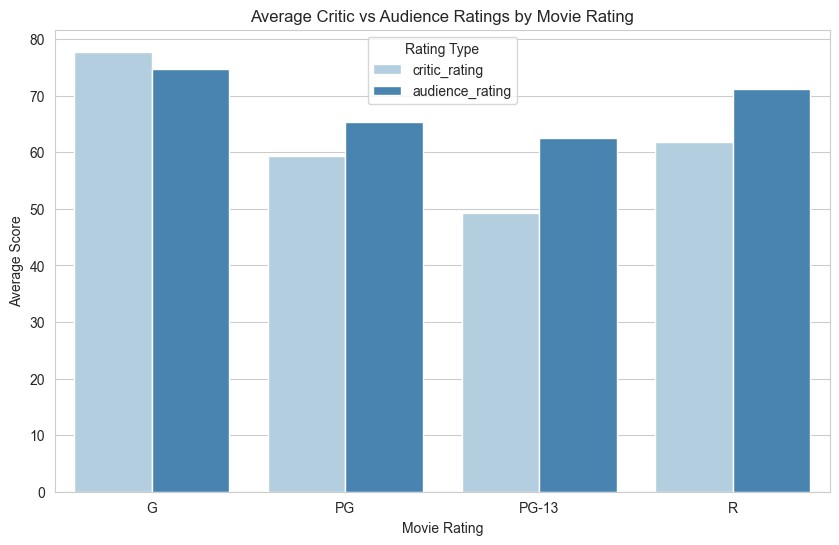

In [170]:
# Create a plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=rating_average,
    x='rating',
    y='average_score',
    hue='rating_type',
    palette='Blues'
)

plt.title("Average Critic vs Audience Ratings by Movie Rating")
plt.xlabel("Movie Rating")
plt.ylabel("Average Score")
plt.legend(title="Rating Type")
plt.show()

##### A Short Summary:
* Most movies are PG-13 and R before 2010, which is the mainstream in Hollywood at that time. In contrast, G-rated movies make up a smaller percentage, which means they are less popular among people.
* G-Rated movies tend to receive higher ratings on average. PG-13 and movies generally show strong audience ratings, suggesting these films target broader appeal and perform well with viewers.

#### 2.5 Create a pair plot of the new DataFrame. What are 3 insights you can take away from looking at the pair plot?

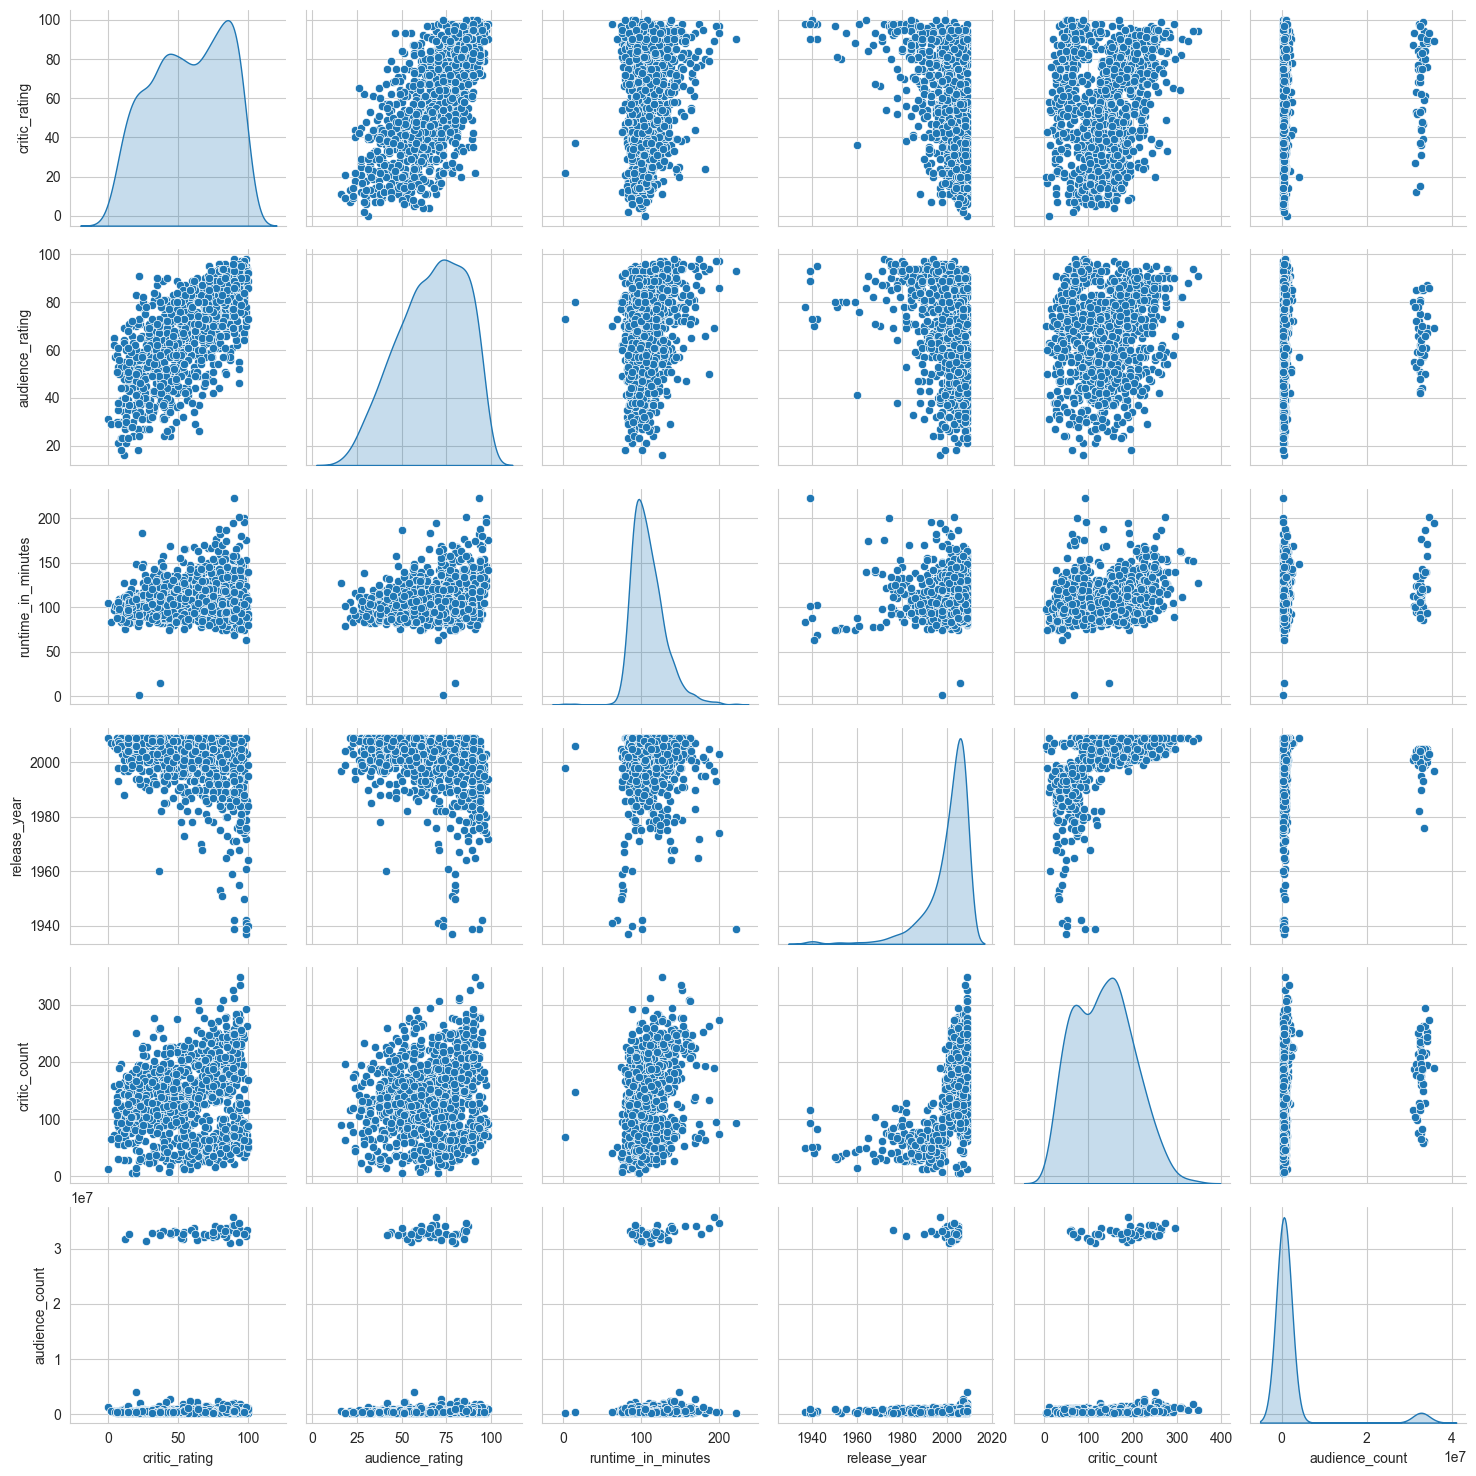

In [171]:
# Keep only numeric columns
numeric_columns = [
    'critic_rating',
    'audience_rating',
    'runtime_in_minutes',
    'release_year',
    'critic_count',
    'audience_count'
]

popular_numeric = popular_movies_pre2010[numeric_columns].dropna()

# Create the plot
sns.pairplot(popular_numeric, diag_kind='kde')
plt.show()

##### A Short Summary:
1. There is a positive relationship between critic_rating and audience_rating, which means that the movies getting high ratings from critics also tend to receive high ratings from general audiences.
2. The correlation between audience_rating and runtime_in_minutes and the relationship between critic_rating and runtime_in_minutes are not strong. In other words, a high-rating movie does not depend on its runtime.
3. The more recent release year, the higher audience/critics review counts, which reflects increased online rating participation with the advent of Internet times.

#### 2.6 Using either pandas or data visualizations, find 3 more insights using any columns in the new DataFrame.

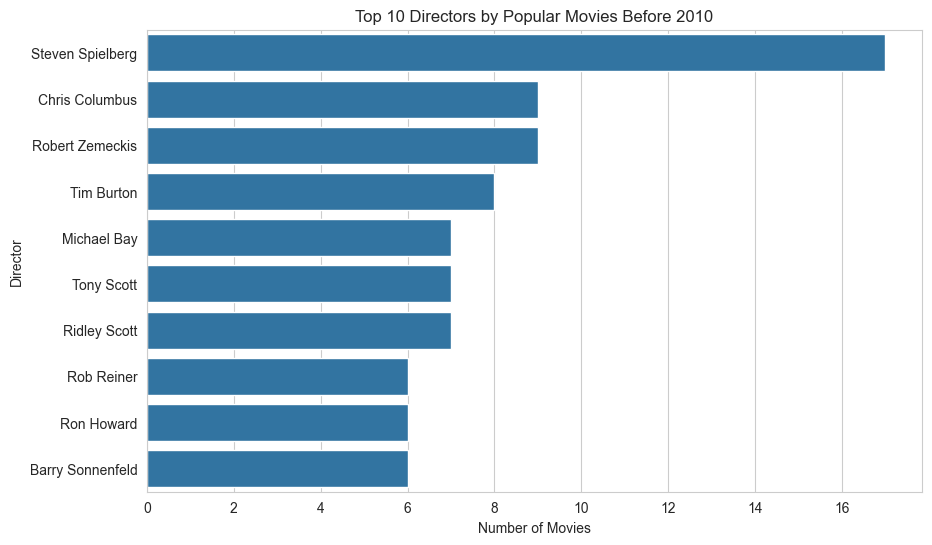

In [172]:
# Insight 1: Top 10 Directors by Popular Movies
top10_directors = popular_movies_pre2010['directors'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(y=top10_directors.index, x=top10_directors.values)
plt.title("Top 10 Directors by Popular Movies Before 2010")
plt.xlabel("Number of Movies")
plt.ylabel("Director")
plt.show()

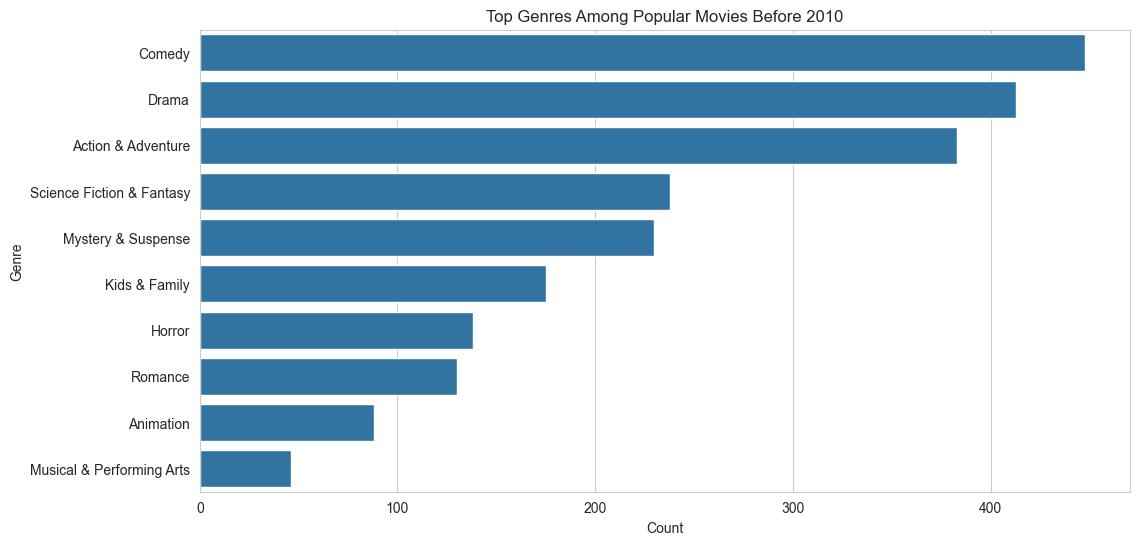

In [173]:
# Insight 2: Top Genres Among Popular Movies Before 2010
# Clean genre column
popular_genres = popular_movies_pre2010.assign(
    genre = popular_movies_pre2010['genre'].str.split(',\\s*')).explode('genre') # Split genres by comma
popular_genres['genre'] = popular_genres['genre'].str.strip() # Clean whitespace
top10_genres = popular_genres['genre'].value_counts().head(10)

# Plot the graph
plt.figure(figsize=(12,6))
sns.barplot(y=top10_genres.index, x=top10_genres.values, orient='h')
plt.title("Top Genres Among Popular Movies Before 2010")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()

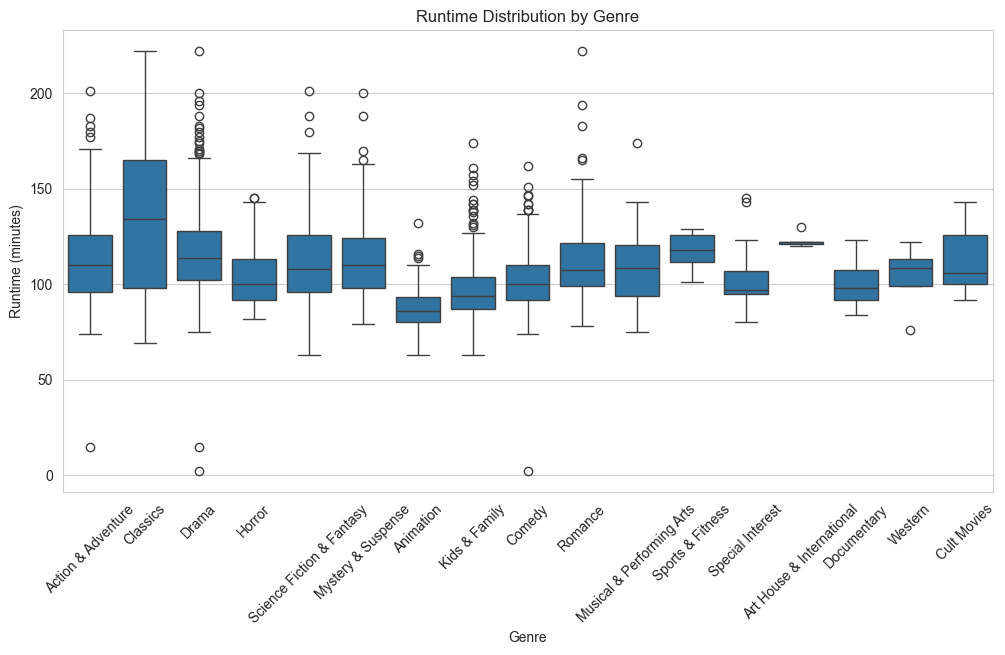

In [174]:
# Insight 3: Runtime Distribution by Genre
plt.figure(figsize=(12,6))
sns.boxplot(data=popular_genres, x='genre', y='runtime_in_minutes')
plt.xticks(rotation=45)
plt.title("Runtime Distribution by Genre")
plt.xlabel("Genre")
plt.ylabel("Runtime (minutes)")
plt.show()

##### A Short Summary:
1. Steven Spielberg stands out as the most influential director among popular movies before 2010. He directed 10 of the movies in the popular subset, more than any other filmmaker. Other high-output directors include Tim Burton, Ridley Scott, and Adam Shankman, each with 6–8 popular films.
This suggests that well-established directors consistently produce commercially successful and widely-viewed movies.
2. Comedy is the most popular genre before 2010, followed by Drama and Action & Adventure, showing that audiences gravitated toward emotionally engaging or high-energy films. Conversely, Musical & Performing Arts is the least common genre in the top 10, indicating weaker overall demand or narrower audience appeal.
3. Classic films have the longest median runtime, as they often include deeper story and slower pacing. Animation films tend to be much shorter, aligning with their target audience and typical production style. This suggests runtime is shaped heavily by genre conventions, not just story complexity.

### 3. Feature Engineering
Your goal is to create a predictive model that will predict the critic_rating. Using the full data set that you originally read into Python (with the erroneous years fixed):

#### 3.1 Split the data into a training and test set, with the training data including movies released in theatres before 2010 and the test data including movies released in theatres in 2010 and after.

In [175]:
train_df = movies[movies['release_year'] < 2010].copy() # training data: movies released in theatres before 2010
test_df = movies[movies['release_year'] >= 2010].copy() # test data: movies released in theatres in 2010 and after
train_df.shape, test_df.shape

((9759, 14), (6064, 14))

#### 3.2 If your goal is to predict the critic_rating before the first critic or audience rating gets posted for a movie, which columns in the data should you NOT use to create features? Update your training and test data sets to NOT include these columns.

In [176]:
columns_to_drop = [
    'critic_rating',
    'audience_rating',
    'audience_count',
    'critic_count'
]

# Update train and test dataset
train_feature = train_df.drop(columns=columns_to_drop)
test_feature = test_df.drop(columns=columns_to_drop)

# Do a train and test split
y_train = train_df['critic_rating']
y_test = test_df['critic_rating']
X_train = train_feature.copy()
X_test = test_feature.copy()

##### A Short Summary:
The goal is to predict the critic rating before any ratings have been posted, so all columns that contain such information are removed. These include critic_rating, audience_rating, audience_count, and critic_count.

#### 3.3 Using only the training data, create a new DataFrame containing the following ID column and features:
* movie_title
* runtime_in_minutes
* NEW: kid_friendly (1 if G or PG, 0 if other ratings)
* NEW: dummy variable columns for each genre

In [177]:
# Add a new column called kid_friendly (1 if G or PG, 0 if other ratings)
train_feature['kid_friendly'] = train_feature['rating'].isin(['G', 'PG']).astype(int)

# Add dummy variable columns for each genre
train_genres = train_feature.assign(
    genre=train_feature['genre'].str.split(r',\s*')).explode('genre') # Split genres by comma
train_genres['genre'] = train_genres['genre'].str.strip() # Clean whitespace

genre_dummies = pd.get_dummies(train_genres['genre'], prefix='genre') # Change the genre format to dummy
genre_dummies_grouped = genre_dummies.groupby(train_genres['movie_title']).max() # Combine genre dummies

# Combine to the final train dataset
train_final = (
    train_feature[['movie_title', 'runtime_in_minutes', 'kid_friendly']]
    .merge(genre_dummies_grouped, left_on='movie_title', right_index=True)
)

train_final

,movie_title,runtime_in_minutes,kid_friendly,genre_Action & Adventure,genre_Animation,genre_Anime & Manga,genre_Art House & International,genre_Classics,genre_Comedy,genre_Cult Movies,...,genre_Horror,genre_Kids & Family,genre_Musical & Performing Arts,genre_Mystery & Suspense,genre_Romance,genre_Science Fiction & Fantasy,genre_Special Interest,genre_Sports & Fitness,genre_Television,genre_Western
2,10,118.0,0,False,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
3,12 Angry Men (Twelve Angry Men),95.0,0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,"20,000 Leagues Under The Sea",127.0,1,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
5,"10,000 B.C.",109.0,0,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
6,The 39 Steps,87.0,0,True,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16631,Zoolander,105.0,0,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
16633,Zoom,88.0,1,True,False,False,False,False,True,False,...,False,True,False,False,False,False,False,False,False,False
16635,Zorba the Greek,142.0,0,True,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
16636,Zulu,139.0,1,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


#### 3.4 Create 3 new features that you think will do a good job predicting the critic_rating. Each new feature should use various combinations of the columns from your training data.

In [178]:
# Feature 1: Convert release_year into decade groups
train_final['decade'] = (train_df['release_year'] // 10) * 10

# Feature 2: Calculate number of genres per movie
genre_cols = [c for c in train_final.columns if c.startswith("genre_")]
train_final["genre_count"] = train_final[genre_cols].sum(axis=1)

# Feature 3: Runtime relative to decade average
decade_mean_runtime = train_final.groupby("decade")["runtime_in_minutes"].transform("mean")
train_final["runtime_ratio"] = train_final["runtime_in_minutes"] / decade_mean_runtime

train_final

,movie_title,runtime_in_minutes,kid_friendly,genre_Action & Adventure,genre_Animation,genre_Anime & Manga,genre_Art House & International,genre_Classics,genre_Comedy,genre_Cult Movies,...,genre_Mystery & Suspense,genre_Romance,genre_Science Fiction & Fantasy,genre_Special Interest,genre_Sports & Fitness,genre_Television,genre_Western,decade,genre_count,runtime_ratio
2,10,118.0,0,False,False,False,False,False,True,False,...,False,True,False,False,False,False,False,1970,2,1.096998
3,12 Angry Men (Twelve Angry Men),95.0,0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,1950,2,0.914013
4,"20,000 Leagues Under The Sea",127.0,1,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,1950,3,1.221892
5,"10,000 B.C.",109.0,0,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,2000,3,1.068718
6,The 39 Steps,87.0,0,True,False,False,False,True,False,False,...,True,False,False,False,False,False,False,1930,3,0.882656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16631,Zoolander,105.0,0,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,2000,2,1.029499
16633,Zoom,88.0,1,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,2000,3,0.862818
16635,Zorba the Greek,142.0,0,True,False,False,True,True,False,False,...,False,False,False,False,False,False,False,1960,4,1.259570
16636,Zulu,139.0,1,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,1960,2,1.232960


### 4. Modeling

#### 4.1 Make sure you apply the same transformations on your X_test and y_test data sets that you applied on the X_train and y_train data sets.

In [179]:
test_final = test_df.copy()

# Add a new column called kid_friendly (1 if G or PG, 0 if other ratings)
test_final["kid_friendly"] = test_final["rating"].isin(["G", "PG"]).astype(int)

# Add dummy variable columns for each genre
test_genres = (test_final.assign(
    genre_list=test_final["genre"].str.split(r",\s*")).explode("genre_list")) # Split genres by comma
test_genres["genre_list"] = test_genres["genre_list"].str.strip() # Clean whitespace

test_genre_dummies = pd.get_dummies(test_genres["genre_list"], prefix="genre") # Change the genre format to dummy
test_genre_dummies_grouped = test_genre_dummies.groupby(test_genres.index).max() # Combine genre dummies

# Combine to the final test dataset
test_final = pd.concat([test_final, test_genre_dummies_grouped], axis=1)

# Align genre columns
genre_cols = [c for c in train_final.columns if c.startswith("genre_")]

# Any missing genre columns in test → add them with 0
for col in genre_cols:
    if col not in test_final.columns:
        test_final[col] = 0

# Remove extra genre columns that appear only in test
test_final = test_final[['movie_title', 'runtime_in_minutes', 'kid_friendly'] + genre_cols]

test_final

,movie_title,runtime_in_minutes,kid_friendly,genre_Action & Adventure,genre_Animation,genre_Anime & Manga,genre_Art House & International,genre_Classics,genre_Comedy,genre_Cult Movies,...,genre_Kids & Family,genre_Musical & Performing Arts,genre_Mystery & Suspense,genre_Romance,genre_Science Fiction & Fantasy,genre_Special Interest,genre_Sports & Fitness,genre_Television,genre_Western,genre_count
0,Percy Jackson & the Olympians: The Lightning T...,83.0,1,True,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,0
1,Please Give,90.0,0,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,0
101,Fireflies in the Garden,98.0,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
134,The Back-up Plan,104.0,0,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,0
136,The Oxford Murders,110.0,0,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16624,Zombeavers,85.0,0,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,0
16629,Zoo,96.0,1,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,0
16630,Zookeeper,101.0,1,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,0
16632,Zoolander 2,102.0,0,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,0


In [180]:
# Feature 1: Convert release_year into decade groups
test_final['decade'] = (test_df['release_year'] // 10) * 10

# Feature 2: Calculate number of genres per movie
test_final['genre_count'] = test_final[genre_cols].sum(axis=1)

# Feature 3: Runtime relative to decade average
test_decade_avg = test_final.groupby('decade')['runtime_in_minutes'].transform('mean')
test_final['runtime_ratio'] = test_final['runtime_in_minutes'] / test_decade_avg

# Split X_test and y_test
X_test = test_final.drop(columns=['movie_title'])
y_test = test_df['critic_rating']

X_train = train_final.drop(columns=['movie_title'])
y_train = train_df['critic_rating']

#### 4.2 Make sure that your X_train, y_train, X_test and y_test data sets only contain columns of numeric and non-null values. Explain and justify how you decide to deal with data issues.

In [182]:
# 1. Drop remaining non-numeric columns
non_numeric_cols = X_train.select_dtypes(include=['object']).columns
X_train = X_train.drop(columns=non_numeric_cols)
X_test  = X_test.drop(columns=non_numeric_cols)

# Convert all boolean columns to int
bool_cols = X_train.select_dtypes(include=['bool']).columns
X_train[bool_cols] = X_train[bool_cols].astype(int)
X_test[bool_cols]  = X_test[bool_cols].astype(int)

# 2. Handle missing values
for col in X_train.columns:
    median_val = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_val)
    X_test[col]  = X_test[col].fillna(median_val)

# Infer objects to remove warnings
X_test = X_test.infer_objects()
X_train = X_train.infer_objects()

# 3. Ensure y-values contain no missing data
y_train = y_train.dropna()
y_test = y_test.dropna()

# Add a quadratic term
X_train["runtime_sq"] = X_train["runtime_in_minutes"]**2
X_test["runtime_sq"] = X_test["runtime_in_minutes"]**2

# 4. Confirm everything is numeric and clean
print("Missing values in X_train:", X_train.isna().sum().sum())
print("Missing values in X_test:", X_test.isna().sum().sum())
print("Dtypes in X_train:", X_train.dtypes.unique())

Missing values in X_train: 0
Missing values in X_test: 0
Dtypes in X_train: [dtype('float64') dtype('int64')]


#### 4.3 Fit 3 linear regression models on the training data:
* Model 1: Use only runtime_in_minutes
* Model 2: Use runtime_in_minutes and kid_friendly
* Model 3: Use runtime_in_minutes, kid_friendly and the dummy columns for the genres

In [183]:
# Identify genre dummy columns
genre_cols = [col for col in X_train.columns if col.startswith("genre_")]

# Model 1: runtime only
features_m1 = ["runtime_in_minutes"]
model1 = LinearRegression()
model1.fit(X_train[features_m1], y_train)

# Model 2: runtime + kid_friendly
features_m2 = ["runtime_in_minutes", "kid_friendly"]
model2 = LinearRegression()
model2.fit(X_train[features_m2], y_train)

# Model 3: runtime + kid_friendly + all genre dummies
features_m3 = ["runtime_in_minutes", "kid_friendly"] + genre_cols
model3 = LinearRegression()
model3.fit(X_train[features_m3], y_train)

# Print results
print("Model 1 Coefficients:", model1.coef_)
print("Model 2 Coefficients:", model2.coef_)
print("Model 3 Coefficients:", model3.coef_[:5], "...")

Model 1 Coefficients: [0.09939288]
Model 2 Coefficients: [0.09981122 2.54743765]
Model 3 Coefficients: [ 0.07198307  2.93566233 -8.0523738   8.1278941  -5.46238269] ...


#### 4.4 Score the linear regression models on the test data by writing a function where you can input the y_test and y_pred values (y_pred = predicted values after you apply the fitted model to your X_test data), and it outputs the following metrics: R2, MAE and RMSE. Apply the function to the three models that you’ve fit so far.

In [184]:
# Define the evaluation function
def evaluate_model(y_test, y_pred, model_name="Model"):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return {"model": model_name, "r2": r2, "mae": mae, "rmse": rmse}

# Generate predictions for each model
y_pred_m1 = model1.predict(X_test[features_m1])
y_pred_m2 = model2.predict(X_test[features_m2])
y_pred_m3 = model3.predict(X_test[features_m3])

# Evaluate all models
results = []
results.append(evaluate_model(y_test, y_pred_m1, "Model 1"))
results.append(evaluate_model(y_test, y_pred_m2, "Model 2"))
results.append(evaluate_model(y_test, y_pred_m3, "Model 3"))

# Display results
results_df = pd.DataFrame(results)
results_df

,model,r2,mae,rmse
0,Model 1,0.001376,24.375345,28.319368
1,Model 2,0.001037,24.413898,28.324169
2,Model 3,0.154660,21.999101,26.055424


#### 4.4 Which model performs the best so far? Which features seem to do a good job predicting the critic rating (hint: you can check p-values using statsmodels)?

In [185]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train[features_m3])
ols_model3 = sm.OLS(y_train, X_train_sm).fit()
ols_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          critic_rating   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     118.6
Date:                Tue, 02 Dec 2025   Prob (F-statistic):               0.00
Time:                        23:48:52   Log-Likelihood:                -45392.
No. Observations:                9759   AIC:                         9.083e+04
Df Residuals:                    9735   BIC:                         9.101e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              43.8322      1.233     35.537      0.000      41.414      46.250
runtime_in_minutes                  0.0720      0.009      7.716      0.000       0.054       0.090
kid_friendly                        2.9357      0.723      4.061      0.000       1.519       4.353
genre_Action & Adventure           -8.0524      0.790    -10.191      0.000      -9.601      -6.503
genre_Animation                     8.1279      1.743      4.663      0.000       4.711      11.544
genre_Anime & Manga                -5.4624      7.818     -0.699      0.485     -20.787       9.862
genre_Art House & International     9.7640      0.854     11.435      0.000       8.090      11.438
genre_Classics                     19.0457      0.870     21.885      0.000      17.340      20.752
genre_Comedy                       -7.3578      0.721    -10.206      0.000      -8.771      -5.945
genre_Cult Movies                  -0.5029      2.634     -0.191      0.849      -5.666       4.661
genre_Documentary                  18.4595      1.555     11.872      0.000      15.412      21.507
genre_Drama                         5.1776      0.737      7.023      0.000       3.733       6.623
genre_Faith & Spirituality        -13.0683      3.331     -3.923      0.000     -19.598      -6.538
genre_Gay & Lesbian                -8.0938      3.157     -2.564      0.010     -14.282      -1.906
genre_Horror                       -8.8034      0.970     -9.078      0.000     -10.704      -6.902
genre_Kids & Family                -6.6155      1.235     -5.357      0.000      -9.036      -4.195
genre_Musical & Performing Arts     1.0609      1.115      0.952      0.341      -1.124       3.246
genre_Mystery & Suspense           -4.4677      0.800     -5.583      0.000      -6.036      -2.899
genre_Romance                      -1.6729      0.887     -1.887      0.059      -3.411       0.065
genre_Science Fiction & Fantasy    -1.2549      0.968     -1.296      0.195      -3.153       0.643
genre_Special Interest              3.3496      1.521      2.203      0.028       0.369       6.331
genre_Sports & Fitness             -0.6589      2.619     -0.252      0.801      -5.793       4.475
genre_Television                    0.1145      1.935      0.059      0.953      -3.678       3.907
genre_Western                       3.3645      1.728      1.947      0.052      -0.023       6.752
genre_count                         2.4532      0.505      4.859      0.000       1.463       3.443
==============================================================================
Omnibus:                      422.013   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              303.937
Skew:                          -0.331   Prob(J

##### A Short Summary:
Models 1 and 2 perform extremely poorly (R² ≈ 0). Runtime and kid_friendly do not meaningfully explain critic ratings on their own. This is expected, because critic_score is influenced by many factors not captured in these variables (director, cast, writing, budget, etc.).

Model 3 shows a major jump in R² (≈ 0.155), meaning that genre is an important predictor. This makes sense: critics rate genres differently. For example, documentaries and dramas are often rated higher than comedies or action films. Model 3 is far better than Models 1 and 2, showing that genre dummies add real predictive signal.

#### 4.5 Try fitting 3 more linear regression models on your own using a combination of the columns so far (runtime_in_minutes, kid-friendly and the dummy columns for genre) and your newly engineered features.
* Each subsequent model should attempt to do a better job at prediction than the previous model (even if the metrics don’t end up being better, your choices should make sense)
* With each new model, explain why you are making your decisions of which feature(s) to include / remove

In [186]:
# Model 4: Model 3 + genre_count
features_m4 = features_m3 + ["genre_count"]
model4 = LinearRegression()
model4.fit(X_train[features_m4], y_train)

# Model 5: Model 4 + runtime_ratio
features_m5 = features_m4 + ["runtime_ratio"]
model5 = LinearRegression()
model5.fit(X_train[features_m5], y_train)

# Model 6: Model 5 + runtime_sq
features_m6 = features_m5 + ["runtime_sq"]
model6 = LinearRegression()
model6.fit(X_train[features_m6], y_train)

# Generate predictions for each model
y_pred_m4 = model4.predict(X_test[features_m4])
y_pred_m5 = model5.predict(X_test[features_m5])
y_pred_m6 = model6.predict(X_test[features_m6])

# Evaluate all models
results.append(evaluate_model(y_test, y_pred_m4, "Model 4"))
results.append(evaluate_model(y_test, y_pred_m5, "Model 5"))
results.append(evaluate_model(y_test, y_pred_m6, "Model 6"))

# Display results
results_df = pd.DataFrame(results)
results_df

,model,r2,mae,rmse
0,Model 1,0.001376,24.375345,28.319368
1,Model 2,0.001037,24.413898,28.324169
2,Model 3,0.154660,21.999101,26.055424
3,Model 4,0.154660,21.999101,26.055424
4,Model 5,0.149498,22.115487,26.134861
5,Model 6,0.153889,22.032113,26.067301


##### A Short Summary:
1. Model 4 has the same performance as Model 3. Even though genre_count could theoretically capture movie “breadth” or cross-genre appeal, it is highly correlated with the individual genre dummy variables already in the model. Thus, it does not add new predictive information.
2. runtime_ratio (runtime relative to decade average) introduces noise without providing useful new information. It may also capture irrelevant era-based variance that the model cannot learn effectively.
3. Adding runtime_sq recovers some lost performance and brings R² back up to 0.1539, very close to Model 3. This suggests a mild non-linear relationship between runtime and critic rating, but not strong enough to surpass Model 3.

#### 4.6 Out of the 6 models you created, which model performs the best? Which features seem to do a good job predicting the critic rating?

Model 3 is the best, the genre dummy variables clearly provide the largest boost in predictive power. This indicates that critic ratings vary meaningfully by genre, and that genre is one of the strongest predictors in the dataset.

In contrast, the additional engineered features tested in Models 4–6 — such as genre_count, runtime_ratio — did not improve performance. These features either duplicated information already encoded in the genre dummies (as with genre_count), or introduced noise / overfitting.

#### 4.7 List 3 other things you could to do at this point to try and improve your model.

1. We can try Ridge or Lasso Regression. It is helpful in addressing multicollinearity among genre dummy variables and prevents overfitting, which often improves prediction accuracy.
2. Maybe we can also add interactions between features such as genre × runtime, runtime × decade. Adding interaction features can help the model capture relationships that are not purely linear.
3. Linear regression is limited because it assumes all relationships are linear. We can try to use Gradient Boosting like LightGBM, which can capture non-linear patterns.